# Simple SMS Spam Classifier

Link to the dataset I've used: https://www.kaggle.com/uciml/sms-spam-collection-dataset/data

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

class SimpleSpamClassifier:
    
    # Simple Spam Classifier 
    
    def __init__(self, model=LogisticRegression(), random_state=None, verbose=False, show_cv_score=True):
        self.random_state = random_state
        self.verbose = verbose
        self.count_vectorizer = None
        self.model = model
        self.show_cv_score = show_cv_score

    def fit(self, data):
        self.count_vectorizer = CountVectorizer()
        self.count_vectorizer.fit(list(data['text'].values))
        
        # sparse matrix in Compressed Sparse Row format
        X = self.count_vectorizer.transform(list(data['text'].values))
        y = data['is_spam'].values
        
        if self.show_cv_score:
            scores = cross_val_score(self.model, X, y, scoring='f1', cv=10)
            print 'CV f1-score (10 folds):', np.mean(scores)
        
        self.model.fit(X, y)
    
    def predict(self, data):
        return self.model.predict_proba(self.count_vectorizer.transform(list(data['text'].values)))


def load_collection(spam_collection_path, sep='\t'):
    sms = pd.read_csv(spam_collection_path, sep=sep, header=None)
    sms.columns=['is_spam', 'text']
    sms['is_spam'] = (sms['is_spam'] == 'spam').astype(int)
    return sms

# load spam collection and split it into TRAIN & TEST
sms = load_collection('SMSSpamCollection.txt')
sms_train, sms_test = train_test_split(sms, test_size=0.2, random_state=1, stratify=sms['is_spam'])

# train SpamClassifier model
model = SimpleSpamClassifier(show_cv_score=True)
model.fit(sms_train)

# predict labels
pred_df = pd.DataFrame(sms_test)
pred_df['pred'] = model.predict(sms_test)[:, 1]

CV f1-score (10 folds): 0.932791644618


In [111]:
pred_df[pred_df.is_spam==1].head()

,is_spam,text,pred
2871,1,YOUR CHANCE TO BE ON A REALITY FANTASY SHOW ca...,0.999329
1628,1,You have been selected to stay in 1 of 250 top...,0.977639
5004,1,CDs 4u: Congratulations ur awarded £500 of CD ...,0.891161
3742,1,2/2 146tf150p,0.010315
4914,1,"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ...",0.378288


# Some examples of correctly classified SPAM objects

In [112]:
for j in range(5):
    print pred_df[(pred_df['pred'] >= 0.5) & (pred_df['is_spam'] == 1)].iloc[j]['text']
    print '-'*50

YOUR CHANCE TO BE ON A REALITY FANTASY SHOW call now = 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national = rate call.
--------------------------------------------------
You have been selected to stay in 1 of 250 top British hotels - FOR NOTHING! Holiday Worth £350! To Claim, Call London 02072069400. Bx 526, SW73SS
--------------------------------------------------
CDs 4u: Congratulations ur awarded £500 of CD gift vouchers or £125 gift guaranteed & Freeentry 2 £100 wkly draw xt MUSIC to 87066 TnCs www.ldew.com1win150ppmx3age16 
--------------------------------------------------
FREE2DAY sexy St George's Day pic of Jordan!Txt PIC to 89080 dont miss out, then every wk a saucy celeb!4 more pics c PocketBabe.co.uk 0870241182716 £3/wk
--------------------------------------------------
Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!
-------------

# Some examples of correctly classified 'HAM' objects

In [113]:
for j in range(5):
    print pred_df[(pred_df['pred'] < 0.5) & (pred_df['is_spam'] == 0)].iloc[j]['text']
    print '-'*50

Ok i shall talk to him
--------------------------------------------------
Eatin my lunch...
--------------------------------------------------
Sir, Waiting for your mail.
--------------------------------------------------
Wif my family booking tour package.
--------------------------------------------------
No. It's not pride. I'm almost  &lt;#&gt;  years old and shouldn't be takin money from my kid. You're not supposed to have to deal with this stuff. This is grownup stuff--why i don't tell you.
--------------------------------------------------


# Some examples of False Negatives

In [114]:
for j in range(5):
    print pred_df[(pred_df['pred'] < 0.5) & (pred_df['is_spam'] == 1)].iloc[j]['text']
    print '-'*50

2/2 146tf150p
--------------------------------------------------
Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry scores with a simple shot from 6 yards from a pass by Bergkamp to give Arsenal a 2 goal margin after 78 mins.
--------------------------------------------------
Missed call alert. These numbers called but left no message. 07008009200
--------------------------------------------------
You have an important customer service announcement from PREMIER.
--------------------------------------------------
Welcome! Please reply with your AGE and GENDER to begin. e.g 24M
--------------------------------------------------


# Confusion matrix

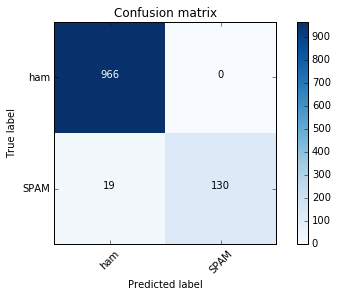

In [115]:
def show_confusion_matrix(y_true, y_pred):
    
    cm = confusion_matrix(y_true, (y_pred >= 0.5).astype(int))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['ham', 'SPAM'] , rotation=45)
    plt.yticks(tick_marks, ['ham', 'SPAM'])
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()
    
show_confusion_matrix(pred_df['is_spam'], pred_df['pred'])